## Transpilers in Exiled 5


Make sure to run each cell that has code if you need it, but at least this first one

In [19]:


import json
answers = []

global_show_answers = False

with open('answers.json') as answer_file: 
    answers = json.load(answer_file)


current_answer = None
show_current_answer_validated = False

def show_answers(allow_answer = False, solution_number = -1):
    global show_current_answer_validated
    global current_answer
    
    if not allow_answer:
        print("Answer not shown due to first parameter")
        show_current_answer_validated = False
        return
    elif (solution_number >= 0) or global_show_answers:
        current_answer = ''.join(open(answers["answers"][solution_number]).readlines())
        show_current_answer_validated = True
    else:
        print("Answer will not be show given the current configuration")
        show_current_answer_validated = False
        

#Test to hide code, for potential future example and try out yourself before seeing answer

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

### What are transpilers

https://harmony.pardeike.net/articles/patching-transpiler.html

A long story short, a transpiler is a method of placing code within existing code. They operate on a IL level basis (Think assembly). A detailed explanation of the general idea of transpilers can be found on the [Harmony Transpilers Page](https://harmony.pardeike.net/articles/patching-transpiler.html)

However, this only goes over how they are used, not how they work. So let's dive deeper

### How they work under the cover

Transpilers work by inserting IL code into the previously existing code through the instructions provided. So, take for example the Exiled example code 


```csharp
 public override void OnEnabled()
{
    RegisterEvents();

    Log.Warn($"I correctly read the string config, its value is: {Config.String}");
    Log.Warn($"I correctly read the int config, its value is: {Config.Int}");
    Log.Warn($"I correctly read the float config, its value is: {Config.Float}");

    base.OnEnabled();
}
```



In C# we have a public function called onEnabled that is void
We have a call to a function defined

We have logger calls

Then we have a base call, calling the base class onEnabled.

Now let's look at the IL version of this 

```
	    /* 0x00000510 00           */ IL_0000: nop
		/* (44,13)-(44,30) 
		/* 0x00000511 02           */ IL_0001: ldarg.0
		/* 0x00000512 281D000006   */ IL_0002: call      instance void Exiled.Example.Example::RegisterEvents()
		/* 0x00000517 00           */ IL_0007: nop
		/* (46,13)-(46,92) 
		/* 0x00000518 72DF000070   */ IL_0008: ldstr     "I correctly read the string config, its value is: "
		/* 0x0000051D 02           */ IL_000D: ldarg.0
		/* 0x0000051E 282100000A   */ IL_000E: call      instance !0 class [Exiled.API]Exiled.API.Features.Plugin`1<class Exiled.Example.Config>::get_Config()
		/* 0x00000523 6F03000006   */ IL_0013: callvirt  instance string Exiled.Example.Config::get_String()
		/* 0x00000528 282200000A   */ IL_0018: call      string [mscorlib]System.String::Concat(string, string)
		/* 0x0000052D 282300000A   */ IL_001D: call      void [Exiled.API]Exiled.API.Features.Log::Warn(string)
		/* 0x00000532 00           */ IL_0022: nop
		/* (47,13)-(47,86) 
		/* 0x00000533 7245010070   */ IL_0023: ldstr     "I correctly read the int config, its value is: {0}"
		/* 0x00000538 02           */ IL_0028: ldarg.0
		/* 0x00000539 282100000A   */ IL_0029: call      instance !0 class [Exiled.API]Exiled.API.Features.Plugin`1<class Exiled.Example.Config>::get_Config()
		/* 0x0000053E 6F05000006   */ IL_002E: callvirt  instance int32 Exiled.Example.Config::get_Int()
		/* 0x00000543 8C54000001   */ IL_0033: box       [mscorlib]System.Int32
		/* 0x00000548 282400000A   */ IL_0038: call      string [mscorlib]System.String::Format(string, object)
		/* 0x0000054D 282300000A   */ IL_003D: call      void [Exiled.API]Exiled.API.Features.Log::Warn(string)
		/* 0x00000552 00           */ IL_0042: nop
		/* (48,13)-(48,90) 
		/* 0x00000553 72AB010070   */ IL_0043: ldstr     "I correctly read the float config, its value is: {0}"
		/* 0x00000558 02           */ IL_0048: ldarg.0
		/* 0x00000559 282100000A   */ IL_0049: call      instance !0 class [Exiled.API]Exiled.API.Features.Plugin`1<class Exiled.Example.Config>::get_Config()
		/* 0x0000055E 6F07000006   */ IL_004E: callvirt  instance float32 Exiled.Example.Config::get_Float()
		/* 0x00000563 8C55000001   */ IL_0053: box       [mscorlib]System.Single
		/* 0x00000568 282400000A   */ IL_0058: call      string [mscorlib]System.String::Format(string, object)
		/* 0x0000056D 282300000A   */ IL_005D: call      void [Exiled.API]Exiled.API.Features.Log::Warn(string)
		/* 0x00000572 00           */ IL_0062: nop
		/* (50,13)-(50,30) 
		/* 0x00000573 02           */ IL_0063: ldarg.0
		/* 0x00000574 282500000A   */ IL_0064: call      instance void class [Exiled.API]Exiled.API.Features.Plugin`1<class Exiled.Example.Config>::OnEnabled()
		/* 0x00000579 00           */ IL_0069: nop
		/* (51,9)-(51,10) 
		/* 0x0000057A 2A           */ IL_006A: ret
```

Woah, that's a lot to look at? Lot's of information in there. What does it mean, how does it work? Well, let's break it down

### How to read IL code

Before we begin, you must understand there are two types of structures we work with. 

1. Stack (Main Stack, MStack)
*  Contains the order of events to occur in general programming terms. However, in this case it is the main stack that holds the reference to itself, and potentially results from function calls. This should be considered the _general storage_ you have limited access to. This contains usually at least (Instance, parameters**) 
2. Evaluation Stack (Temporary Stack, EStack)
*  Contains information that is used when calling functions, it contains information passed onto it by the developer. This of this as a temporary array for you to use during the functions lifetime for _temporary storage_. 


`/* 0x00000510 00           */ IL_0000: nop ` 

**nop**: This is a no operation call, in functions they serve as a signal for the CPU to pass the next cycle. This means that the computer is told to either do nothing, something else, or anything. The computer processor simply moves to the next sequential instruction but it provides two things. 

1. A delay
2. A breakpoint accessible location for debuggers.

Overall, this is a non factor a majority of the time

So at this point, our stack's look like

EStack []

`/* 0x00000511 02           */ IL_0001: ldarg.0`

**ldarg.0**: This is an instruction you can read more about here [Opcodes.Ldarg_0](https://docs.microsoft.com/en-us/dotnet/api/system.reflection.emit.opcodes.ldarg_0?view=net-6.0). However, to give a general explanation - ldarg.0 is the instance which is usually a reference to itself. Keep in mind for static methods this is the first argument instead. This goes on the main stack we refer to earlier. 

So at this point, our stack's look like

EStack [Instance]

`/* 0x00000512 281D000006   */ IL_0002: call      instance void Exiled.Example.Example::RegisterEvents()` 

**call**: [Opcodes.Call](https://docs.microsoft.com/en-us/dotnet/api/system.reflection.emit.opcodes.call?view=net-6.0). Call is your way of invoking a non-virtual, static, or superclass method, i.e., the target of the call is not subject to overriding function. Since this function does not require any parameters, and is void it does not need to access the Eval stack. 

`/* 0x00000517 00           */ IL_0007: nop` See nop above

`/* 0x00000518 72DF000070   */ IL_0008: ldstr     "I correctly read the string config, its value is: "` 
**ldstr** [Opcodes.Ldstr](https://docs.microsoft.com/en-us/dotnet/api/system.reflection.emit.opcodes.ldstr?view=net-6.0). Ldstr is your way of loading a string to your stack to be used. 

So at this point, our stack's look like

EStack ["I correctly.."]



#### Now going forward, we have a lot of calls to underlying functions. I am not going to describe them all in detail but I will explain each new thing we encounter as we go forward

`/* 0x0000051E 282100000A   */ IL_000E: call      instance !0 class [Exiled.API]Exiled.API.Features.Plugin`
`1<class Exiled.Example.Config>::get_Config()`
**call**: See above

EStack ["I correctly..", Config]


`/* 0x00000523 6F03000006   */ IL_0013: callvirt  instance string Exiled.Example.Config::get_String()`
**callvirt** [Opcodes.Callvirt](https://docs.microsoft.com/en-us/dotnet/api/system.reflection.emit.opcodes.callvirt?view=net-6.0). Callvirt is your way of invoking a function that is virtual, non-static, non-superclass method. This means normally you would want to call your function utilizing this if you are doing any instance method calls. Otherwise, call is required.

`/* 0x00000528 282200000A   */ IL_0018: call      string [mscorlib]System.String::Concat(string, string)
/* 0x0000052D 282300000A   */ IL_001D: call      void [Exiled.API]Exiled.API.Features.Log::Warn(string)
/* 0x00000532 00           */ IL_0022: nop
/* (47,13)-(47,86) 
/* 0x00000533 7245010070   */ IL_0023: ldstr     "I correctly read the int config, its value is: {0}"
/* 0x00000538 02           */ IL_0028: ldarg.0
/* 0x00000539 282100000A   */ IL_0029: call      instance !0 class [Exiled.API]Exiled.API.Features.Plugin`
`1<class Exiled.Example.Config>::get_Config()
/* 0x0000053E 6F05000006   */ IL_002E: callvirt  instance int32 Exiled.Example.Config::get_Int()`

So at this point, our stack's look like

EStack ["I correctly read the int config, its value is: {0}", get_int() ]

`/* 0x00000543 8C54000001   */ IL_0033: box      [mscorlib]System.Int32`
**box** [Opcodes.Box](https://docs.microsoft.com/en-us/dotnet/api/system.reflection.emit.opcodes.box?view=net-6.0).
Box converts a value type to an object reference. This means, we are converting the last item on the EStack to whatever type it is supposed to be, in this case, int32.

`/* 0x00000548 282400000A   */ IL_0038: call     string [mscorlib]System.String::Format(string, object)
/* 0x0000054D 282300000A   */ IL_003D: call      void [Exiled.API]Exiled.API.Features.Log::Warn(string)
/* 0x00000552 00           */ IL_0042: nop
/* (48,13)-(48,90) 
/* 0x00000553 72AB010070   */ IL_0043: ldstr     "I correctly read the float config, its value is: {0}"
/* 0x00000558 02           */ IL_0048: ldarg.0
/* 0x00000559 282100000A   */ IL_0049: call      instance !0 class [Exiled.API]Exiled.API.Features.Plugin`
`1<class Exiled.Example.Config>::get_Config()
/* 0x0000055E 6F07000006   */ IL_004E: callvirt  instance float32 Exiled.Example.Config::get_Float()
/* 0x00000563 8C55000001   */ IL_0053: box       [mscorlib]System.Single
/* 0x00000568 282400000A   */ IL_0058: call      string [mscorlib]System.String::Format(string, object)
/* 0x0000056D 282300000A   */ IL_005D: call      void [Exiled.API]Exiled.API.Features.Log::Warn(string)`


So at this point, our stack's look like

EStack []

`/* 0x00000572 00           */ IL_0062: nop
/* (50,13)-(50,30) 
/* 0x00000573 02           */ IL_0063: ldarg.0
/* 0x00000574 282500000A   */ IL_0064: call      instance void class [Exiled.API]Exiled.API.Features.Plugin`
`1<class Exiled.Example.Config>::OnEnabled()
/* 0x00000579 00           */ IL_0069: nop
/* (51,9)-(51,10) 
/* 0x0000057A 2A           */ IL_006A: ret`

So at this point, our stack's look like

EStack []


## Woah that was a lot

Yes, it is. So, let's take a break and think about what we just saw. We saw that we were able to store variables into a stack, and that calls were put into their own stack. We saw that information was pulled from our MStack to EStack to be used in function calls. We saw that we get nested levels of calls, and information associated.

### Where do we go from here?

Now, what we can do is use this information to insert instructions into various calls. However, let's start simple as we can and try to inject our own IL code by looking at Exiled

In order to achieve an inject, we need to use Harmony. This tool allows us to inject our own IL code into the assembly itself. Let's dive in

[Example code](https://github.com/Exiled-Team/EXILED/blob/dev/Exiled.Events/Patches/Events/Player/ChangingGroup.cs)

```csharp
namespace Exiled.Events.Patches.Events.Player
{
#pragma warning disable SA1118
    using System.Collections.Generic;
    using System.Reflection.Emit;

    using Exiled.Events.EventArgs;

    using HarmonyLib;

    using NorthwoodLib.Pools;

    using UnityEngine;

    using static HarmonyLib.AccessTools;

    /// <summary>
    /// Patches <see cref="ServerRoles.SetGroup(UserGroup, bool, bool, bool)"/>.
    /// Adds the <see cref="ChangingGroup"/> event.
    /// </summary>
    [HarmonyPatch(typeof(ServerRoles), nameof(ServerRoles.SetGroup))]
    internal static class ChangingGroup
    {
        private static IEnumerable<CodeInstruction> Transpiler(IEnumerable<CodeInstruction> instructions, ILGenerator generator)
        {
            List<CodeInstruction> newInstructions = ListPool<CodeInstruction>.Shared.Rent(instructions);

            Label returnLabel = generator.DefineLabel();

            int offset = 1;

            int index = newInstructions.FindIndex(instruction => instruction.opcode == OpCodes.Ret) + offset;

            // var ev = new ChangingGroupEventArgs(Player, UserGroup, true);
            //
            // if (!ev.IsAllowed)
            //     return;
            
            newInstructions.InsertRange(index, new[]
            {
                new CodeInstruction(OpCodes.Ldarg_0).MoveLabelsFrom(newInstructions[index]),
                new(OpCodes.Call, PropertyGetter(typeof(ServerRoles), nameof(ServerRoles.gameObject))),
                new(OpCodes.Call, Method(typeof(API.Features.Player), nameof(API.Features.Player.Get), new[] { typeof(GameObject) })),
                new(OpCodes.Ldarg_1),
                new(OpCodes.Ldc_I4_1),
                new(OpCodes.Newobj, GetDeclaredConstructors(typeof(ChangingGroupEventArgs))[0]),
                new(OpCodes.Dup),
                new(OpCodes.Call, Method(typeof(Handlers.Player), nameof(Handlers.Player.OnChangingGroup))),
                new(OpCodes.Callvirt, PropertyGetter(typeof(ChangingGroupEventArgs), nameof(ChangingGroupEventArgs.IsAllowed))),
                new(OpCodes.Brfalse_S, returnLabel),
            });

            newInstructions[newInstructions.Count - 1].labels.Add(returnLabel);

            for (int z = 0; z < newInstructions.Count; z++)
                yield return newInstructions[z];

            ListPool<CodeInstruction>.Shared.Return(newInstructions);
        }
    }
}
```

Let's break it down the same way we did before

`[HarmonyPatch(typeof(ServerRoles), nameof(ServerRoles.SetGroup))]`
This is provided above your class (A class you can defined to whatever name you want) to tell harmony what we are going to modify. You can learn more here [Harmony patching](https://harmony.pardeike.net/articles/patching.html). However, the general idea is that you provide harmony the type of Class we are trying to modify, and the method we are trying to modify. Something to keep in mind is that you cannot change fields, or other types that are locked in, such as enums. See here [Harmony limitations](https://harmony.pardeike.net/articles/patching-edgecases.html)

` internal static class ChangingGroup` 
Our class

`private static IEnumerable<CodeInstruction> Transpiler(IEnumerable<CodeInstruction> instructions, ILGenerator generator)`
Harmony requires all patch's be static, as it needs to be able to access it very early on. This means that whether it's a prefix, postfix, transpiler, or reverse-patch - they need to be static. The rest of the line includes:

`IEnumerable` (Think advanced vector with iterator)
CodeInstruction (A wrapper around OpCodes we saw above [Harmony CodeInstruction](https://harmony.pardeike.net/api/HarmonyLib.CodeInstruction.html), meaning we will need to use Harmony's version of OpCodes to mimic behavior)


`Transpiler` (The type of patch method we want to use) 

`IEnumerable<CodeInstruction>` instructions (IEnumerable + Code Instruction) as parameter (The already compiled IL (opcode))
    
`ILGenerator generator` (Generator generates segments of method bodies. [Microsoft IL generated code])(https://docs.microsoft.com/en-us/dotnet/api/system.reflection.emit.ilgenerator?view=net-6.0))


    
`List<CodeInstruction> newInstructions = ListPool<CodeInstruction>.Shared.Rent(instructions);`

This will be the list of instructions we will be adding. ListPool is a generalized syncronized pool around IPool to allow safe behavior, renting some allocation on the queue. Additionally, we are copying over all the original instructions so that we can append/insert where needed

`Label returnLabel = generator.DefineLabel();`

This allows us to keep track of the original IL code meaning we can branch back over to it utilizing a label. Think GOTO 

`int offset = 1;`

We normally do not want to overwrite the original ldarg.0 call.


`int index = newInstructions.FindIndex(instruction => instruction.opcode == OpCodes.Ret) + offset;`

We are setting variable index to the first position where the instructions in the original code has a return. Meaning, if we look at the original SetGroup code, we can see where that is

```csharp
[ServerCallback]
public void SetGroup(global::UserGroup group, bool ovr, bool byAdmin = false, bool disp = false)
{
if (!NetworkServer.active)
{
    return; <--- 
}
```

in IL it would look like

```csharp
/* 0x0004BC50 281300000A   */ IL_0000: call      bool [Mirror]Mirror.NetworkServer::get_active()
/* 0x0004BC55 3A01000000   */ IL_0005: brtrue    IL_000B

/* 0x0004BC5A 2A           */ IL_000A: ret <----
```


This means when we call that FindIndex, we can Hex A which is 10. Now that we know where we are, we will do the following:

```csharp 
// var ev = new ChangingGroupEventArgs(Player, UserGroup, true);
//
// if (!ev.IsAllowed)
//     return;
```

Now let's look at how it's done

The objective is to define a variable to use, and if the event called gets overriden by someone else (Exiled event += onEnabled adds a event catch) we will check if the event can be used, else return


```csharp
newInstructions.InsertRange(index, new[]
{
    new CodeInstruction(OpCodes.Ldarg_0).MoveLabelsFrom(newInstructions[index]),
    new(OpCodes.Call, PropertyGetter(typeof(ServerRoles), nameof(ServerRoles.gameObject))),
    new(OpCodes.Call, Method(typeof(API.Features.Player), nameof(API.Features.Player.Get), new[] { typeof(GameObject) })),
    new(OpCodes.Ldarg_1),
    new(OpCodes.Ldc_I4_1),
    new(OpCodes.Newobj, GetDeclaredConstructors(typeof(ChangingGroupEventArgs))[0]),
    new(OpCodes.Dup),
    new(OpCodes.Call, Method(typeof(Handlers.Player), nameof(Handlers.Player.OnChangingGroup))),
    new(OpCodes.Callvirt, PropertyGetter(typeof(ChangingGroupEventArgs), nameof(ChangingGroupEventArgs.IsAllowed))),
    new(OpCodes.Brfalse_S, returnLabel),
    new(OpCodes.Ret),
});
```

In this code, we do the following

`newInstructions.InsertRange` Our instructions to add `(index, new[] { });` and the instructions to add from {}

`new CodeInstruction(OpCodes.Ldarg_0).MoveLabelsFrom(newInstructions[index]),` 
Our first instruction which is to copy over all of the previous branch label information from our current position in the original code (Remember our position is 1 + return meaning right after it)

Now that we are after the if condition, and have all the branching information, we can then begin to add our own logic 
(Notice: This is not necessarily the case in all transpilers, see [049 Recall](https://github.com/Exiled-Team/EXILED/blob/dev/Exiled.Events/Patches/Events/Scp049/StartingAndFinishingRecall.cs)

Which will be akin to `/* 0x00000511 02           */ IL_0001: ldarg.0`

So now our stack's are:


EStack [ServerGroup]

`new(OpCodes.Call, PropertyGetter(typeof(ServerRoles), nameof(ServerRoles.gameObject))),`

Remember our call earlier? This will resolve to the same thing, meaning what will happen is we will generate opcode in which it will use our EStack instance. This means it will look akin to

`
/* 0x00000512 281D000006   */ IL_0002: call      class [ServerRoles]ServerRoles.gameObject
`


So now our stack's are

EStack [GameObject]

`new(OpCodes.Call, Method(typeof(API.Features.Player), nameof(API.Features.Player.Get), new[] { typeof(GameObject) })),`

Again, we now do another call, utilizing the object we just added to our stack to call the Player.Get function akin to

`/* 0x00000512 281D000006   */ IL_0002: call      class [API.Features.Player)]API.Features.Player.Get(class)`

So now our stack's are

EStack [Player]

Next steps are to load our arguments onto the eval stack 

`
new(OpCodes.Ldarg_1),
new(OpCodes.Ldc_I4_1),
`



This is the equivilant to 

` 
ldarg.1 Copy arguemnt 1 from MStack to EStack 
ldc.i4.1
`

So now our stack's are

EStack [Player, User group, 1]

`new(OpCodes.Newobj, GetDeclaredConstructors(typeof(ChangingGroupEventArgs))[0]),`

Next to generate a new object with the parameters we've passed

Player, 1, (Default value is in function call)

Equivialant to 
`newobj    instance void [ChangingGroupEventArgs]Exiled.Events.EventArgs.ChangingGroupEventArgs::.ctor()`

So now our stack's are


EStack [ChangingGroupEventArgs]

Thereafter we have 
`
new(OpCodes.Dup),
new(OpCodes.Call, Method(typeof(Handlers.Player), nameof(Handlers.Player.OnChangingGroup))),
new(OpCodes.Callvirt, PropertyGetter(typeof(ChangingGroupEventArgs), nameof(ChangingGroupEventArgs.IsAllowed))),
new(OpCodes.Brfalse_S, returnLabel),
new(OpCodes.Ret)
`

Which breaks down to

`new(OpCodes.Dup)` copy our last EStack item and duplicate it again on the EStack

So now our stack are

EStack [ChangingGroupEventArgs, ChangingGroupEventArgs]

`new(OpCodes.Call, Method(typeof(Handlers.Player), nameof(Handlers.Player.OnChangingGroup))),`

Calls the OnChangingGroup function, to make sure it gets the ev.IsAllowed event information

`new(OpCodes.Callvirt, PropertyGetter(typeof(ChangingGroupEventArgs), nameof(ChangingGroupEventArgs.IsAllowed))),`

Utilizes our last ChangingGroupEventArgs which may have been modified by the previous call *(which gets called by anyone who subscribed)* and saves it in MStack

So now our stack's are

EStack [ChangingGroupEventArgs, ChangingGroupEventArgs.IsAllowed]

`
new(OpCodes.Brfalse_S, returnLabel),
new(OpCodes.Ret),
`

Now we check, if the isAllowed, our last item on the MStack is null then we will branch to the original logic. Otherwise, we will return

So, all of this to do

```csharp
// var ev = new ChangingGroupEventArgs(Player, UserGroup, true);
//
// if (!ev.IsAllowed)
//     return;

```

However, let's expand this. Utilizing what we learned earlier, let's try to add a print statement to this code. 

Let's attempt to create the following
```csharp
// var ev = new ChangingGroupEventArgs(Player, UserGroup, true);
//
// if (!ev.IsAllowed){
//     Log.Info("Changing group events were not allowed");
//     return;
// }

```



In order to achieve this, we need to look back at our previous example of log. 

`* 0x00000518 72DF000070   */ IL_0008: ldstr     "I correctly read the string config, its value is: "
        /* 0x0000051D 02           */ IL_000D: ldarg.0
        /* 0x0000051E 282100000A   */ IL_000E: call      instance !0 class [Exiled.API]Exiled.API.Features.Plugin1<class Exiled.Example.Config>::get_Config()
        /* 0x00000523 6F03000006   */ IL_0013: callvirt  instance string Exiled.Example.Config::get_String()
        /* 0x00000528 282200000A   */ IL_0018: call      string [mscorlib]System.String::Concat(string, string)
        /* 0x0000052D 282300000A   */ IL_001D: call      void [Exiled.API]Exiled.API.Features.Log::Warn(string)
`

And look back at the code written in Harmony's transpiler wrapper.


```csharp
    List<CodeInstruction> newInstructions = ListPool<CodeInstruction>.Shared.Rent(instructions);

    Label returnLabel = generator.DefineLabel();

    int offset = 1;

    int index = newInstructions.FindIndex(instruction => instruction.opcode == OpCodes.Ret) + offset;

    // var ev = new ChangingGroupEventArgs(Player, UserGroup, true);
    //
    // if (!ev.IsAllowed)
    //     return;

    newInstructions.InsertRange(index, new[]
    {
        new CodeInstruction(OpCodes.Ldarg_0).MoveLabelsFrom(newInstructions[index]),
        new(OpCodes.Call, PropertyGetter(typeof(ServerRoles), nameof(ServerRoles.gameObject))),
        new(OpCodes.Call, Method(typeof(API.Features.Player), nameof(API.Features.Player.Get), new[] { typeof(GameObject) })),
        new(OpCodes.Ldarg_1),
        new(OpCodes.Ldc_I4_1),
        new(OpCodes.Newobj, GetDeclaredConstructors(typeof(ChangingGroupEventArgs))[0]),
        new(OpCodes.Dup),
        new(OpCodes.Call, Method(typeof(Handlers.Player), nameof(Handlers.Player.OnChangingGroup))),
        new(OpCodes.Callvirt, PropertyGetter(typeof(ChangingGroupEventArgs), nameof(ChangingGroupEventArgs.IsAllowed))),
        new(OpCodes.Brfalse_S, returnLabel),
    });

    newInstructions[newInstructions.Count - 1].labels.Add(returnLabel);

    for (int z = 0; z < newInstructions.Count; z++)
        yield return newInstructions[z];

    ListPool<CodeInstruction>.Shared.Return(newInstructions);
```

Now I will leave the exercise to the reader but will put the answer below. Up to you to decide if you want to see the answer immediately or would rather try it out then look.

In [25]:
show_current_answer = False
current_question = 0

show_answers(show_current_answer, current_question)

if(show_current_answer_validated):
    print(current_answer)

Answer not shown due to first parameter


## General understanding 

Hopefully by this point, we now have a general understanding of how to generally look at, and read IL code, and Transpiler Harmony code. If not, please go back through and re-read. If it is still confusing or errors were made, open a PR and it'll be fixed. 

Assuming we have no major issues thus far, congratulations. You've now got a general basic grasp of how these two components, IL code, and Transpilers work. Going forward, the objective will be, I will give you scenarios to fill in your answers into for both IL, and Transpiler equivilants, and will evaluate the answer in that fashion. You can of course cheat but, no benefit will be gained. 

### Now, let's go unto other examples..

1. LoadsField, StoresField looking for calls
2. Reference calls
3. Try catch

--- 
1. In this part, we will attempt to find a specific place to add our code by checking for a specific loading of a field. We will then insert code (Based on the context you will see), and verify it works
2. In this part, we will attempt to call a function that has a reference variable. Meaning, an out or ref variable in a function.
3. In this part, we will attempt to add a try catch, and then a try catch where we throw an exception.

For now, here are the three sections of code we will evalute.

1. https://github.com/Exiled-Team/EXILED/blob/2d315cf56be0b1e2481e0090495caa0e740cfda8/Exiled.Events/Patches/Events/Scp244/UpdateScp244.cs
2. https://github.com/Exiled-Team/EXILED/blob/2d315cf56be0b1e2481e0090495caa0e740cfda8/Exiled.Events/Patches/Events/Scp330/InteractingScp330.cs
3. https://github.com/Undid-Iridium/CleanupUtility/blob/main/CleanupUtility/Patches/ServerCreatePickupPatch.cs 

#### Part 1, LoadsField

##### What is LoadsField?

Well, LoadsField is a method that is provided by the CodeInstruction class (Which is provided by harmony). It allows you to specify a Field that you define to be compared against. So, for example:

```csharp
int index = newInstructions.FindIndex(instruction => instruction.LoadsField(Field(typeof(Scp244DeployablePickup), nameof(Scp244DeployablePickup._activationDot)))) + offset;
```

In this example, we are looking to find an instruction (The first one we can find (FindIndex)) where it attempts to load a field. Now, keep in mind with our previous exampples that we can define a Field (One without get; set;) with a Field method call. In this case, we do ```Field(typeof(Scp244DeployablePickup), nameof(Scp244DeployablePickup._activationDot))``` which resolves to `Scp244DeployablePickup._activationDot` Field. This means that when the opcode is being iterated on, it will compare the emit opcode type to a ldsfld or ldfld type. Then the opcode will be compared based on its operand type, meaning, it will compare if the operand (opcode object) resolves to the same Field we passed. Now, all of this happens under the cover, the only thing you, as a developer need to worry about it the following:

1. Ensure your Field, is only a Field, if it is a get; set; you will need to modify your LoadsField to something else (You will see an example later on)
2. If it is a Field then all you need to do is specify the specific type of Field, and LoadsField will identify the location for you.



Here is a direct example from Exiled. In this example, you will see the usage of LoadsField, and code associated. 

```csharp
// -----------------------------------------------------------------------
// <copyright file="UpdateScp244.cs" company="Exiled Team">
// Copyright (c) Exiled Team. All rights reserved.
// Licensed under the CC BY-SA 3.0 license.
// </copyright>
// -----------------------------------------------------------------------

namespace Exiled.Events.Patches.Events.Scp244
{
    /// <summary>
    /// Patches <see cref="Scp244DeployablePickup"/> to add missing event handler to the <see cref="Scp244DeployablePickup"/>.
    /// </summary>
    [HarmonyPatch(typeof(Scp244DeployablePickup), nameof(Scp244DeployablePickup.UpdateRange))]
    internal static class UpdateScp244
    {
        private static IEnumerable<CodeInstruction> Transpiler(IEnumerable<CodeInstruction> instructions, ILGenerator generator)
        {
            List<CodeInstruction> newInstructions = ListPool<CodeInstruction>.Shared.Rent(instructions);
            
            // Labels are for branching
            Label normalProcessing = generator.DefineLabel();

            // LocalBuilders should be considered the same as local variables.
            LocalBuilder resultOfDotCheck = generator.DeclareLocal(typeof(int));

#pragma warning disable SA1118 // Parameter should not span multiple lines

            int offset = 1;
            int index = newInstructions.FindIndex(instruction => instruction.LoadsField(Field(typeof(Scp244DeployablePickup), nameof(Scp244DeployablePickup._activationDot)))) + offset;

            // Remove branching on dot result.
            newInstructions.RemoveAt(index);
```

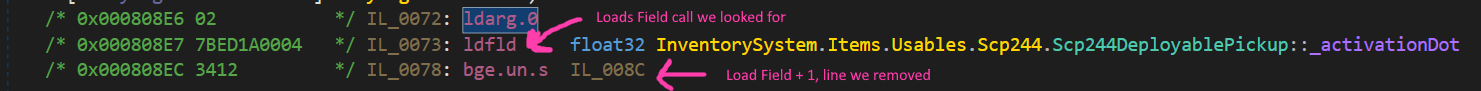

```csharp
            newInstructions.InsertRange(index, new[]
            {
                // EStack [Vector3Dot, ActivationDot], compare if left is less than right
                new CodeInstruction(OpCodes.Clt),
                
                // EStack [Clt], store it in local variable we defined earlier.
                new(OpCodes.Stloc, resultOfDotCheck.LocalIndex),

                // EStack[], Store instance of program. Remember, non-static functions means arg0 is always instance.
                new(OpCodes.Ldarg_0),
            
                // EStack[Instance], Load our saved clt value
                new(OpCodes.Ldloc, resultOfDotCheck.LocalIndex),

                // EStack[Instance, clt], now we will pass these two variables to a ctor (newobj creation) for OpeningScp244EventArgs. 
                // The reason why we need [0] is because we may have multiple constructors we could call so we need to be specific.
                new(OpCodes.Newobj, GetDeclaredConstructors(typeof(OpeningScp244EventArgs]))[0]),

                // EStack[OpeningScp244EventArgs], now we will copy OpeningScp244EventArgs again to allow us to use it twice
                new(OpCodes.Dup),

                // EStack[OpeningScp244EventArgs, OpeningScp244EventArgs], now we will call the OnOpeningScp244 func which returns nothing
                // This call basically allows any delegate who is hooked (event https://docs.microsoft.com/en-us/dotnet/csharp/language-reference/keywords/event)
                new(OpCodes.Call, Method(typeof(Handlers.Scp244), nameof(Handlers.Scp244.OnOpeningScp244))),
                
                // EStack[OpeningScp244EventArgs] Now we use our last copy of the OpeningScp244EventArgs to check if the event can be allowed.
                // See here how isAllowed is a field but has get; set;. meaning, we must call the instance with a propertygetter. The reason is
                // because get; set is really just abstracted getter and setter functions, meaning it's a function call rather than an accessor.
                new(OpCodes.Callvirt, PropertyGetter(typeof(OpeningScp244EventArgs), nameof(OpeningScp244EventArgs.IsAllowed))),

                // Assuming event should be allowed, continue in the original if condition, otherwise, skip over.
                new(OpCodes.Brfalse_S, normalProcessing),
            });

            int continueOffset = -1;
            // Find the last instruction that calls state (which is after the if condition), and insert ourselves there.
            int continueIndex = newInstructions.FindLastIndex(instruction => instruction.Calls(PropertyGetter(typeof(Scp244DeployablePickup), nameof(Scp244DeployablePickup.State)))) + continueOffset;

            // Jumping over original NW logic. Placing label so we can jump here.
            newInstructions[continueIndex].WithLabels(normalProcessing);

            for (int z = 0; z < newInstructions.Count; z++)
                yield return newInstructions[z];

            ListPool<CodeInstruction>.Shared.Return(newInstructions);
        }
    }
}
```

### Test your knowledge!

How would you find this index

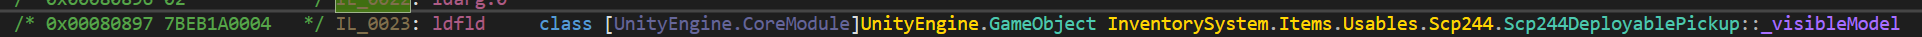

In [23]:
show_current_answer = False
current_question = 1

show_answers(show_current_answer, current_question)

if(show_current_answer_validated):
    print(current_answer)

Answer not shown due to first parameter


Now if you found that one, how would then find this one?
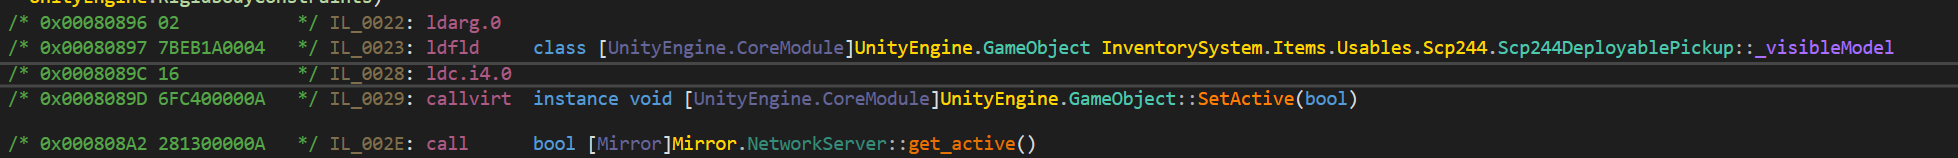

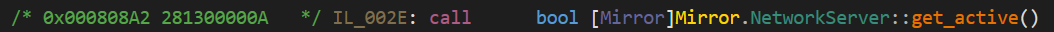

In [24]:
show_current_answer = False
current_question = 2

show_answers(show_current_answer, current_question)

if(show_current_answer_validated):
    print(current_answer)

Answer not shown due to first parameter


#### Part 2, Reference Calls


```csharp
// -----------------------------------------------------------------------
// <copyright file="InteractingScp330.cs" company="Exiled Team">
// Copyright (c) Exiled Team. All rights reserved.
// Licensed under the CC BY-SA 3.0 license.
// </copyright>
// -----------------------------------------------------------------------

namespace Exiled.Events.Patches.Events.Scp330
{
    using System;
#pragma warning disable SA1118
#pragma warning disable SA1313

    using System.Collections.Generic;
    using System.Reflection;
    using System.Reflection.Emit;

    using CustomPlayerEffects;

    using Exiled.API.Features;
    using Exiled.Events.EventArgs;

    using Footprinting;

    using HarmonyLib;

    using Interactables.Interobjects;

    using InventorySystem;
    using InventorySystem.Items.Usables.Scp330;
    using InventorySystem.Searching;

    using NorthwoodLib.Pools;

    using UnityEngine;

    using static HarmonyLib.AccessTools;

    /// <summary>
    /// Patches the <see cref="Scp330Interobject.ServerInteract"/> method to add the <see cref="Handlers.Scp330.InteractingScp330"/> event.
    /// </summary>
    [HarmonyPatch(typeof(Scp330Interobject), nameof(Scp330Interobject.ServerInteract))]

    public static class InteractingScp330
    {
        private static IEnumerable<CodeInstruction> Transpiler(IEnumerable<CodeInstruction> instructions, ILGenerator generator)
        {
            List<CodeInstruction> newInstructions = ListPool<CodeInstruction>.Shared.Rent(instructions);

            Label continueProcessing = generator.DefineLabel();

            Label shouldNotSever = generator.DefineLabel();

            Label returnLabel = generator.DefineLabel();

            LocalBuilder eventHandler = generator.DeclareLocal(typeof(InteractingScp330EventArgs));

            // Remove original "No scp can touch" logic.
            newInstructions.RemoveRange(0, 5);

            // Find ServerPickupProcess, insert before it.
            int offset = -3;
            int index = newInstructions.FindLastIndex(instruction => instruction.Calls(Method(typeof(Scp330Bag), nameof(Scp330Bag.ServerProcessPickup)))) + offset;

            newInstructions.InsertRange(index, new[]
            {
                new CodeInstruction(OpCodes.Ldarg_1).MoveLabelsFrom(newInstructions[index]),

                new(OpCodes.Call, Method(typeof(Player), nameof(Player.Get), new[] { typeof(ReferenceHub) })),

                new(OpCodes.Ldloc_2),

                new(OpCodes.Newobj, GetDeclaredConstructors(typeof(InteractingScp330EventArgs))[0]),

                new(OpCodes.Dup),

                new(OpCodes.Stloc, eventHandler.LocalIndex),

                new(OpCodes.Ldloc, eventHandler.LocalIndex),

                new(OpCodes.Call, Method(typeof(Handlers.Scp330), nameof(Handlers.Scp330.OnInteractingScp330))),

                new(OpCodes.Callvirt, PropertyGetter(typeof(InteractingScp330EventArgs), nameof(InteractingScp330EventArgs.IsAllowed))),

                new(OpCodes.Brfalse, returnLabel),
            });

            // Logic to find the only ServerProcessPickup and replace with our own.
            int removeServerProcessOffset = -2;
            int removeServerProcessIndex = newInstructions.FindLastIndex(instruction => instruction.Calls(Method(typeof(Scp330Bag), nameof(Scp330Bag.ServerProcessPickup)))) + removeServerProcessOffset;

            newInstructions.RemoveRange(removeServerProcessIndex, 3);

            Label ignoreOverlay = generator.DefineLabel();

            // Remove NW server process logic.
            newInstructions.InsertRange(removeServerProcessIndex, new[]
            {
                new CodeInstruction(OpCodes.Ldloc, eventHandler),

                new CodeInstruction(OpCodes.Callvirt, PropertyGetter(typeof(InteractingScp330EventArgs), nameof(InteractingScp330EventArgs.Candy))),

                new CodeInstruction(OpCodes.Ldloca_S, 3),

                new CodeInstruction(OpCodes.Call, Method(typeof(InteractingScp330), nameof(InteractingScp330.ServerProcessPickup), new[] { typeof(ReferenceHub), typeof(CandyKindID), typeof(Scp330Bag).MakeByRefType() })),
            });

            // This is to find the location of RpcMakeSound to remove the original code and add a new sever logic structure (Start point)
            int addShouldSeverOffset = 1;
            int addShouldSeverIndex = newInstructions.FindLastIndex(instruction => instruction.Calls(Method(typeof(Scp330Interobject), nameof(Scp330Interobject.RpcMakeSound)))) + addShouldSeverOffset;

            // This is to find the location of the next return (End point)
            int includeSameLine = 1;
            int nextReturn = newInstructions.FindIndex(addShouldSeverIndex, instruction => instruction.opcode == OpCodes.Ret) + includeSameLine;

            // Remove original code from after RpcMakeSound to next return and then fully replace it.
            newInstructions.RemoveRange(addShouldSeverIndex, nextReturn - addShouldSeverIndex);

            addShouldSeverIndex = newInstructions.FindLastIndex(instruction => instruction.Calls(Method(typeof(Scp330Interobject), nameof(Scp330Interobject.RpcMakeSound)))) + addShouldSeverOffset;

            newInstructions.InsertRange(addShouldSeverIndex, new[]
            {
                new CodeInstruction(OpCodes.Ldloc, eventHandler.LocalIndex),

                new (OpCodes.Callvirt, PropertyGetter(typeof(InteractingScp330EventArgs), nameof(InteractingScp330EventArgs.ShouldSever))),

                new (OpCodes.Brfalse, shouldNotSever),

                new CodeInstruction(OpCodes.Ldarg_1),

                new CodeInstruction(OpCodes.Ldfld, Field(typeof(ReferenceHub), nameof(ReferenceHub.playerEffectsController))),

                new CodeInstruction(OpCodes.Ldstr, nameof(SeveredHands)),

                new CodeInstruction(OpCodes.Ldc_R4, 0f),

                new CodeInstruction(OpCodes.Ldc_I4_0),

                new CodeInstruction(OpCodes.Callvirt, Method(typeof(PlayerEffectsController), nameof(PlayerEffectsController.EnableByString), new[] { typeof(string), typeof(float), typeof(bool) })),

                new CodeInstruction(OpCodes.Pop),

                new CodeInstruction(OpCodes.Ret),
            });

            // This will let us jump to the taken candies code and lock until ldarg_0, meaning we allow base game logic handle candy adding.
            int addTakenCandiesOffset = -1;

            int addTakenCandiesIndex = newInstructions.FindLastIndex(instruction => instruction.LoadsField(Field(typeof(Scp330Interobject), nameof(Scp330Interobject._takenCandies)))) + addTakenCandiesOffset;
            newInstructions[addTakenCandiesIndex].WithLabels(shouldNotSever);

            newInstructions[newInstructions.Count - 1].labels.Add(returnLabel);

            for (int z = 0; z < newInstructions.Count; z++)
                yield return newInstructions[z];

            ListPool<CodeInstruction>.Shared.Return(newInstructions);
        }

        private static bool ServerProcessPickup(ReferenceHub ply, CandyKindID candy, out Scp330Bag bag)
        {
            if (!Scp330Bag.TryGetBag(ply, out bag))
            {
                ply.inventory.ServerAddItem(ItemType.SCP330, ushort.MinValue);
                if (!Scp330Bag.TryGetBag(ply, out bag))
                {
                    return false;
                }

                bag.Candies = new List<CandyKindID> { candy };
                bag.ServerRefreshBag();
                return true;
            }

            bool result = bag.TryAddSpecific(candy);

            if (bag.AcquisitionAlreadyReceived)
            {
                bag.ServerRefreshBag();
            }

            return result;
        }
    }
}
```

#### Part 3, Try Catch

```csharp
// -----------------------------------------------------------------------
// <copyright file="ServerCreatePickupPatch.cs" company="Undid-Iridium">
// Copyright (c) Undid-Iridium. All rights reserved.
// Licensed under the CC BY-SA 3.0 license.
// </copyright>
// -----------------------------------------------------------------------

#pragma warning disable SA1118

namespace CleanupUtility.Patches
{
    using System;
    using System.Collections.Generic;
    using System.Reflection.Emit;
    using Exiled.API.Enums;
    using Exiled.API.Features;
    using Exiled.API.Features.Items;
    using HarmonyLib;
    using InventorySystem;
    using NorthwoodLib.Pools;
    using static HarmonyLib.AccessTools;

    /// <summary>
    /// Patches <see cref="InventoryExtensions.ServerCreatePickup"/> to add <see cref="Pickup"/>s to the <see cref="PickupChecker"/>.
    /// </summary>
    [HarmonyPatch(typeof(InventoryExtensions), nameof(InventoryExtensions.ServerCreatePickup))]
    internal static class ServerCreatePickupPatch
    {
        private static IEnumerable<CodeInstruction> Transpiler(IEnumerable<CodeInstruction> instructions, ILGenerator generator)
        {
            List<CodeInstruction> newInstructions = ListPool<CodeInstruction>.Shared.Rent(instructions);

            LocalBuilder itemZone = generator.DeclareLocal(typeof(ZoneType));

            int index = newInstructions.FindIndex(instruction => instruction.opcode == OpCodes.Ldarg_1);

            Label skipLabel = generator.DefineLabel();
            Label continueProcessing = generator.DefineLabel();
            Label skipException = generator.DefineLabel();

            LocalBuilder exceptionObject = generator.DeclareLocal(typeof(Exception));

            // Our Catch (Try wrapper) block
            ExceptionBlock catchBlock = new (ExceptionBlockType.BeginCatchBlock, typeof(Exception));

            // Our Exception handling start
            ExceptionBlock exceptionStart = new (ExceptionBlockType.BeginExceptionBlock, typeof(Exception));

            // Our Exception handling end
            ExceptionBlock exceptionEnd = new (ExceptionBlockType.EndExceptionBlock);

            newInstructions.InsertRange(index, new[]
            {
                // Load ItemBase to EStack
                new CodeInstruction(OpCodes.Ldarg_0).WithBlocks(exceptionStart).MoveLabelsFrom(newInstructions[index]),

                // Assign unspecified enum as the default value, and then try to load the actual value
                new CodeInstruction(OpCodes.Ldc_I4_4),

                // Then save the player zone to a local variable (This is all done early because spawn deletes information and made it default to surface)
                new CodeInstruction(OpCodes.Stloc, itemZone.LocalIndex),

                // Load EStack to callvirt and get owner back on Estack
                new CodeInstruction(OpCodes.Callvirt, PropertyGetter(typeof(Inventory), nameof(Inventory.gameObject))),

                new CodeInstruction(OpCodes.Call, Method(typeof(ReferenceHub), nameof(ReferenceHub.GetHub), new[] { typeof(UnityEngine.GameObject) })),

                // Duplicate ItemBase.Owner (if null then two nulls)
                new CodeInstruction(OpCodes.Dup),

                // If previous owner is null, escape this, still have one null on stack if that is the case
                new CodeInstruction(OpCodes.Brfalse_S, skipLabel),

                // Using Owner call Player.Get static method with it (Reference hub) and get a Player back, OK game object could be null
                new CodeInstruction(OpCodes.Call, Method(typeof(Player), nameof(Player.Get), new[] { typeof(ReferenceHub) })),

                // Then get the player Zone (This was probably null)
                new CodeInstruction(OpCodes.Callvirt, PropertyGetter(typeof(Player), nameof(Player.Zone))),

                // Continue without calling broken escape route
                new CodeInstruction(OpCodes.Br_S, continueProcessing),

                // Remove current null from stack. Default value setting ZoneType to unspecified if previous owner is null by escaping to this label
                new CodeInstruction(OpCodes.Pop).WithLabels(skipLabel),

                // Then save the player zone to a local variable (This is all done early because spawn deletes information and made it default to surface)
                new CodeInstruction(OpCodes.Stloc, itemZone.LocalIndex).WithLabels(continueProcessing),

                // Correctly esacpes try-catch block.
                new CodeInstruction(OpCodes.Leave_S, skipException),

                // Load the exception from stack
                new CodeInstruction(OpCodes.Nop, exceptionObject.LocalIndex).WithBlocks(catchBlock).WithBlocks(exceptionEnd),

                // Allows original logic to run.
                new CodeInstruction(OpCodes.Nop).WithLabels(skipException),
            });

            index = newInstructions.FindLastIndex(instruction => instruction.opcode == OpCodes.Ldloc_0);
            newInstructions.InsertRange(index, new[]
            {
                // Calls static instance
                new CodeInstruction(OpCodes.Call, PropertyGetter(typeof(Plugin), nameof(Plugin.Instance))),

                // Since the instance is now on the stack, we will call ProperttyGetter to get to PickupChecker object from our Instance object
                new CodeInstruction(OpCodes.Callvirt, PropertyGetter(typeof(Plugin), nameof(Plugin.PickupChecker))),

                /*
                 *      .maxstack 4
                        .locals init (
                            [0] class InventorySystem.Items.Pickups.ItemPickupBase,
                            [1] valuetype InventorySystem.Items.Pickups.PickupSyncInfo
                        )
                */

                // Load the variable unto Eval Stack [ItemPickupBase]
                new CodeInstruction(OpCodes.Ldloc_0),

                // Calls pickup method using local variable 0 (Which is on Eval Stack [ItemPickupBase]) and it gets back a Pickup object onto the EStack [Pickup]
                new CodeInstruction(OpCodes.Call, Method(typeof(Pickup), nameof(Pickup.Get))),

                // Calls arguemnt 1 from function call unto EStack (Zone)
                new CodeInstruction(OpCodes.Ldloc, itemZone.LocalIndex),

                // EStack variable used, [PickupChecker (Callvirt arg 0 (Instance)), Pickup (Arg 1 (Param))]
                new CodeInstruction(OpCodes.Callvirt, Method(typeof(PickupChecker), nameof(PickupChecker.Add), new[] { typeof(Pickup), typeof(ZoneType) })),
            });

            for (int z = 0; z < newInstructions.Count; z++)
            {
                yield return newInstructions[z];
            }

            ListPool<CodeInstruction>.Shared.Return(newInstructions);
        }
    }
}
```

https://harmony.pardeike.net/articles/patching-transpiler.html

https://www.kenneth-truyers.net/2016/05/12/yield-return-in-c/

https://docs.microsoft.com/en-us/dotnet/api/system.reflection.emit.ilgenerator.emit?view=net-6.0#system-reflection-emit-ilgenerator-emit(system-reflection-emit-opcode-system-reflection-emit-label)